In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import time

df = pd.read_csv('cardData.csv')

df.head()

# Yes is 1 and No is 0

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [9]:
print(df.isnull().values.any())
print(df.isnull().sum().sum())

df = df.dropna()

print(df.isnull().values.any())
print(df.isnull().sum().sum())


False
0
False
0


<AxesSubplot:>

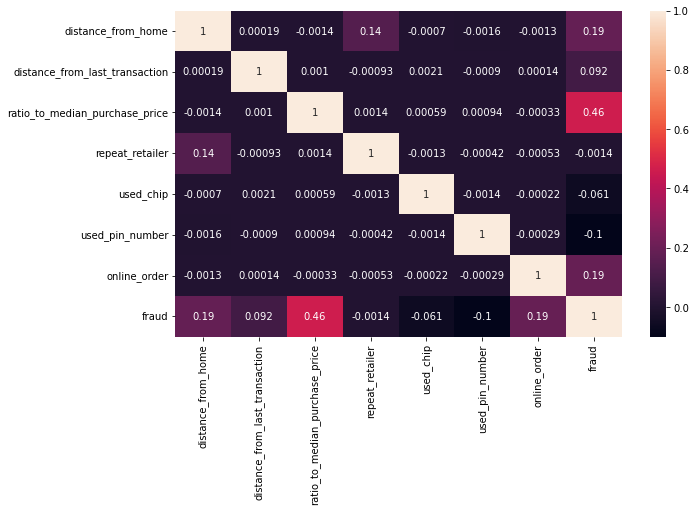

In [10]:
cor = df.corr()

plt.figure(figsize = (10,6))
sns.heatmap(data = cor, annot = True)

In [11]:
#sns.barplot(data = df, x = "used_pin_number", y = "fraud")

In [12]:
#sns.barplot(data = df, x = "repeat_retailer", y = "fraud")

In [13]:
#sns.barplot(data = df, x = "online_order", y = "fraud")

In [14]:
#sns.barplot(data = df, x = "used_chip", y = "fraud")

In [15]:
length = len(df.index)
splitPoint = int(length * 0.7)
train = df[0:splitPoint]
test = df[splitPoint:length]

In [16]:
df.drop(columns = ['distance_from_home','distance_from_last_transaction','repeat_retailer'], axis =1 , inplace =True)


In [17]:
# K-NN Training Algorithm
def trainKNN(df, iterations):
  '''
  Pseudocode Algorithm
  1. Set K to 3 because this is the first odd value greater than the number of categories in the Titanic dataset.
  2. Create an empty list to collect accuracy values during training.
  2. Segment the training dataset into three equal parts: 
    - Segment 1: Class 1 labels
    - Segment 2: Class 2 labels
    - Segment 3: Remaining data of "unknown" labels 
  3. Calculate the euclidean distance between each data point in segment 3 with all data in segment 1 and segment 2. 
  4. Take the top K smallest distances to determine the label of the "unknown" data point.
  5. Append 0 to accuracy list if the label does not match the actual label. Append 1 to accuracy list if the label does match the actual label.
  6. Calculate the overall accuracy percent of the K value and append it to a dictionary of k, accuracy values.
  7. Add 2 to K and repeat steps 3 - 6 for a desired number of iterations.
  '''
  # Set initial value of k
  k = 3

  # Segment training data into 3 segments.
  class1, class2, unknowns = getSegments(df)
  
  # Calculate accuracy of K values for desired iterations
  count = 0
  accuracies = {}
  t0 = time.time() # for measuring how long it takes to compute
  t0_k = k
  while count < iterations:
    if count % 10 == 0:
      elapsed = time.time() - t0
      t0 = time.time()
      print(f"Took {elapsed:.2f} seconds to compute {t0_k}<=k<{k}")
      t0_k = k
    # Calculate percent accuracy for current k
    accuracy_at_k = calculateAccuracy(class1, class2, unknowns, k)
    accuracies[k] = accuracy_at_k
    k = k + 100000 # change this
    count = count + 1
  
  return accuracies

In [18]:
def getSegments(df):
  # Segment training data into 3 segments. If not divisible by 3, add extra data to unknown segment.
  length = len(df.index)
  splitPoint = int(length/3)
  fraud = df[df.fraud == 1]
  notFraud = df[df.fraud == 0]
  fraud_df = fraud.iloc[:splitPoint]
  notfraud_df = notFraud.iloc[:splitPoint]
  leftover = pd.concat([fraud.iloc[splitPoint:], notFraud.iloc[splitPoint:]])
  fraud.reset_index(inplace=True, drop=True)
  notFraud.reset_index(inplace=True, drop=True)
  leftover.reset_index(inplace=True, drop=True)
  return fraud_df, notfraud_df, leftover

In [19]:
cache = {}
def calculateAccuracy(class1, class2, unknowns, k):
  known = pd.concat([class1, class2], axis=0)
  unknown_prediction_correct = []
  for idx in unknowns.index:
    if not idx in cache:
      cache[idx] = known.apply(lambda x: euclidianDistance(x, unknowns.iloc[idx]), axis=1)
    known['distance_to_unknown'] = cache[idx]
    top_k = known.sort_values('distance_to_unknown',ascending=True).head(k)
    predicted_class = top_k.value_counts(ascending=False, subset='fraud').index[0] # TODO: double check this line
    unknown_prediction_correct.append(1 if predicted_class == unknowns.iloc[idx].fraud else 0)
    known.pop('distance_to_unknown') # remove this so we don't use it in future distance calculations
  return sum(unknown_prediction_correct) / len(unknown_prediction_correct)

In [20]:
def euclidianDistance(row1, row2):
  sum = 0
  for (i, j) in zip(row1[1:10], row2[1:10]):
    diffSQ = (i - j) **2
    sum = sum + diffSQ
  return math.sqrt(sum)

In [ ]:
performance = trainKNN(train, 10)

Took 0.00 seconds to compute 3<=k<3


In [ ]:
print(performance)